In [105]:
import torch
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

### Hyperparameters ###
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 10

In [106]:
# Funzione per creare coppie di immagini e etichettarli con "maggiore", "minore" o "uguale"
def create_image_pairs(dataset):
    image_pairs = []
    labels = []

    for i in range(len(dataset)):
        img_A, label_A = dataset[i]

        # Seleziona un'altra immagine casuale
        idx_B = random.randint(0, len(dataset) - 1)
        img_B, label_B = dataset[idx_B]
        # Determina la relazione tra le etichette
        if label_A > label_B:
            relation_label = 0  # A > B
        elif label_A < label_B:
            relation_label = 1  # A < B
        else:
            relation_label = 2  # A = B

        # Aggiungi la coppia e la relazione
        image_pairs.append((img_A, img_B))
        labels.append(relation_label)

    return image_pairs, labels

In [107]:
# Dataset personalizzato per gestire le coppie di immagini
class MNISTPairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.image_pairs, self.labels = create_image_pairs(dataset)

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img_A, img_B = self.image_pairs[idx]
        label = self.labels[idx]

        # Concatenare le immagini lungo il canale (depth)
        concatenated_image = torch.cat((img_A, img_B), dim=0)

        return concatenated_image, label


In [108]:
# Funzione per visualizzare una coppia di immagini e la loro etichetta di relazione
def show_image_pair(img_A, img_B, relation_label):
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Converte il tensore in numpy array per visualizzazione
    img_A = img_A.squeeze().numpy()  # Rimuove la dimensione del canale
    img_B = img_B.squeeze().numpy()

    # Crea una figura con due immagini, riducendo la dimensione per occupare meno spazio
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))  # Dimensioni ridotte

    # Mostra le immagini
    axes[0].imshow(img_A, cmap='gray')
    axes[0].set_title('Image A')
    axes[0].axis('off')  # Rimuove gli assi

    axes[1].imshow(img_B, cmap='gray')
    axes[1].set_title('Image B')
    axes[1].axis('off')  # Rimuove gli assi

    # Riduce lo spazio tra i subplots
    plt.tight_layout(pad=0.5)  # Riduce il padding tra le immagini

    # Mostra il titolo della relazione
    plt.suptitle(f'Relation: {relation_labels[relation_label]}', y=0.85)  # Posiziona il titolo più vicino
    plt.show()


In [109]:
# Funzione per visualizzare più coppie di immagini in un'unica figura
def show_dataset(dataset, num_images=5):
    dataiter = iter(dataset)
    images, labels = next(dataiter)

    # Mappa delle etichette di relazione
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Numero di righe: ogni riga contiene 1 coppia di immagini (2 colonne)
    num_rows = num_images  # 1 coppia per riga

    # Crea una griglia di subplots: num_rows righe, 3 colonne (Image A, Relation, Image B)
    fig, axes = plt.subplots(num_rows, 3, figsize=(6, num_rows * 2))
    
    for i in range(num_images):
        concatenated_image = images[i]
        label = labels[i].item()

        img_A = concatenated_image[0, :, :]
        img_B = concatenated_image[1, :, :]

        # Mostra l'immagine A nel subplot
        axes[i, 0].imshow(img_A, cmap='gray')
        axes[i, 0].set_title('Image A')
        axes[i, 0].axis('off')

        # Mostra l'etichetta di relazione nel subplot centrale
        axes[i, 1].text(0.5, 0.5, f'Relation: {relation_labels[label]}', 
                        fontsize=12, ha='center', va='center')
        axes[i, 1].axis('off')

        # Mostra l'immagine B nel subplot
        axes[i, 2].imshow(img_B, cmap='gray')
        axes[i, 2].set_title('Image B')
        axes[i, 2].axis('off')  # Nascondi gli assi

    # Applica il layout compatto per ridurre lo spazio tra i subplot
    plt.tight_layout(pad=0.5)
    plt.show()


In [110]:
# Definisci la funzione per aggiungere rumore gaussiano
def add_gaussian_noise(tensor, mean=0.0, std=0.05):
    return tensor + std * torch.randn_like(tensor) + mean

In [111]:
# Definisci la funzione per invertire i colori
def invert_colors(tensor):
    return 1 - tensor

In [112]:
# Trasformo le immagini in tensori e normalizzo i valori secondo le statiche del dataset MNIST
transform_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Applico data augmentation sul dataset di training
transform_augmented = transforms.Compose([
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.RandomChoice([
        transforms.Lambda(lambda x: add_gaussian_noise(x)),
        transforms.Lambda(lambda x: invert_colors(x)),
        transforms.Lambda(lambda x: x),
    ]),
    transforms.Normalize((0.1307,), (0.3081,))
])

if not TRANSFORM_DATASET and not AUGMENT_DATASET:
    train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_norm)

    train_pair_dataset = MNISTPairDataset(train_dataset)

    print(f"Dimensione del dataset originale: {len(train_pair_dataset)}")

if TRANSFORM_DATASET:
    train_dataset_transformed = datasets.MNIST(root='./data', train=True, download=True,
                                                transform=transform_augmented)
    
    train_pair_dataset = MNISTPairDataset(train_dataset_transformed)
    print(f"Dimensione del dataset trasformato: {len(train_pair_dataset)}")

if AUGMENT_DATASET:
    train_dataset_augmented = datasets.MNIST(root='./data', train=True, download=True,
                                                transform=transform_augmented)
    train_pair_dataset_augmented = MNISTPairDataset(train_dataset_augmented)
    train_pair_dataset = torch.utils.data.ConcatDataset([train_pair_dataset, train_pair_dataset_augmented])

    print(f"Dimensione del dataset aumentato: {len(train_pair_dataset_augmented)}")
    print(f"Dimensione del dataset combinato: {len(train_pair_dataset)}")

train_loader = torch.utils.data.DataLoader(
                            train_pair_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)



Dimensione del dataset originale: 60000


In [113]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_norm)

test_pair_dataset = MNISTPairDataset(test_dataset)
test_loader = torch.utils.data.DataLoader(test_pair_dataset, batch_size=BATCH_SIZE, shuffle=False)

total_test_size = len(test_dataset)

validation_split = 0.2
validation_size = int(total_test_size * validation_split)
test_size = total_test_size - validation_size

# Suddividi il dataset di test
test_subset, validation_subset = torch.utils.data.random_split(test_pair_dataset, [test_size, validation_size])

# Crea i DataLoader per il test set e il validation set
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_subset, batch_size=BATCH_SIZE, shuffle=False)


In [114]:
print("Size train: ", len(train_loader), " Size test: ", len(test_loader), " Size validation: ", len(validation_loader))

Size train:  938  Size test:  125  Size validation:  32


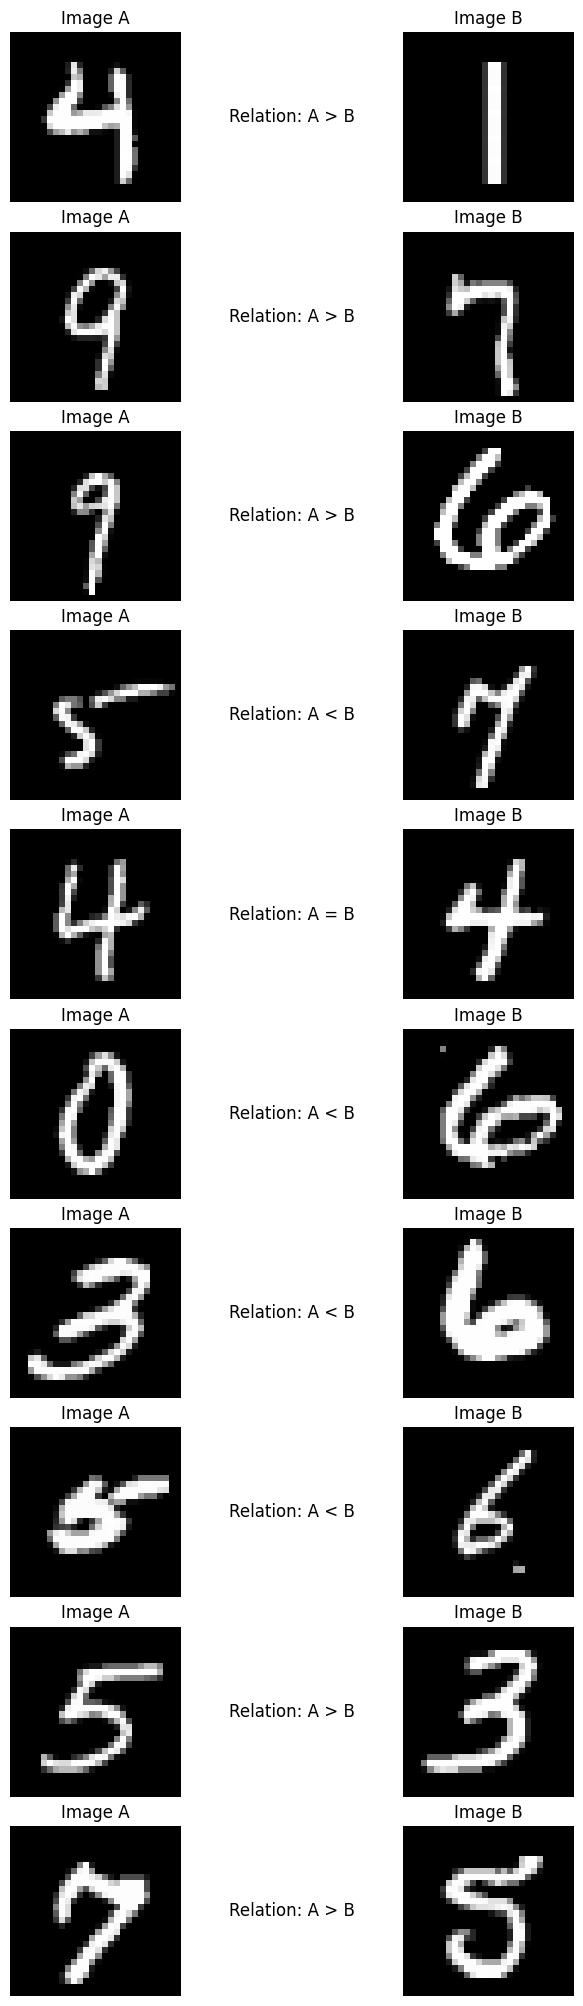

In [115]:
if PRINT_IMG:
    show_dataset(train_loader, 10)

In [116]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [117]:
import torch.nn as nn
import torch.nn.functional as F

class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [118]:
# define Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [119]:
model.train()

for epoch in range(EPOCHS):
    model.train()

    for i, data in enumerate(train_loader):
        images, labels = data

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)  # Usa le immagini concatenate
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/10], Loss: 0.6184
Epoch [2/10], Loss: 0.6412
Epoch [3/10], Loss: 0.4264
Epoch [4/10], Loss: 0.5122
Epoch [5/10], Loss: 0.4727
Epoch [6/10], Loss: 0.2958
Epoch [7/10], Loss: 0.3961
Epoch [8/10], Loss: 0.3720
Epoch [9/10], Loss: 0.2256
Epoch [10/10], Loss: 0.3224
Finished Training
